# Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from scipy.signal import windows


# Reproducibility

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# For extra determinism (may reduce performance on some models):
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Global Configuration and Paths

In [5]:
URBAN_DIR = "UrbanSound8k"
METADATA_PATH = os.path.join(URBAN_DIR, "metadata", "UrbanSound8k.csv")

SR = None
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 40
FIXED_TIME_FRAMES = 130
WINDOW_TYPES = ["rect", "hann", "hamming"]
NUM_CLASSES = 10

EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Manual STFT implementation

In [6]:
def window_nonzero(window_function, segment_length):
    zero_exist = True
    zero_count = 0
    window_vector = window_function(segment_length + zero_count)
    while zero_exist:
        start = int(zero_count / 2)
        stop  = len(window_vector) - int(zero_count / 2)
        window_vector = window_vector[start:stop]
        zero_count = len(window_vector) - np.count_nonzero(window_vector)
        if zero_count > 0:
            window_vector = window_function(segment_length + zero_count)
        else:
            zero_exist = False
    return window_vector

def create_overlapping_segments(x, segment_length, shift_length):
    x = np.squeeze(x)
    start_list = np.arange(0, x.shape[0], shift_length)
    stop_list  = start_list + segment_length
    valid_mask = (stop_list <= x.shape[0])
    start_list = start_list[valid_mask]
    stop_list  = stop_list[valid_mask]
    if stop_list[-1] != x.shape[0]:
        stop_list  = np.append(stop_list, x.shape[0])
        start_list = np.append(start_list, x.shape[0] - segment_length)
    segments = [x[s:t] for s,t in zip(start_list, stop_list)]
    x_segments = np.stack(segments, axis=1)
    return x_segments, start_list, stop_list

def stft_snippet(x, segment_length, segment_length_padded, shift_length, window_function):
    window_vec = window_nonzero(window_function, segment_length)
    x_segments, start_list, stop_list = create_overlapping_segments(x, segment_length, shift_length)
    x_segments = x_segments * window_vec[:, None]
    X_stft = np.fft.rfft(x_segments, n=segment_length_padded, axis=0)
    return X_stft, start_list, stop_list

def snippet_stft_wrapper(y, n_fft=1024, hop_length=512, window='rect'):
    if window == 'rect':
        win_func = windows.boxcar
    elif window == 'hann':
        win_func = windows.hann
    elif window == 'hamming':
        win_func = windows.hamming
    else:
        raise ValueError(f"Unknown snippet window: {window}")
    seg_len = n_fft
    seg_len_padded = n_fft
    shift_len = hop_length
    X_stft, _, _ = stft_snippet(y, seg_len, seg_len_padded, shift_len, win_func)
    S_mag = np.abs(X_stft)
    return S_mag


# Global Feature cache

In [4]:
FEATURE_CACHE = {}

# Feature extraction

In [7]:
def extract_feature_melspectrogram(audio_path, window_type='hann'):

    cache_key = (audio_path, window_type)
    if cache_key in FEATURE_CACHE:
        return FEATURE_CACHE[cache_key]

    y, sr = librosa.load(audio_path, sr=SR)

    if window_type == 'rect':
        S_mag = snippet_stft_wrapper(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window='rect')
        
    elif window_type == 'hann':
        D = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window='hann')
        S_mag = np.abs(D)
        
    elif window_type == 'hamming':
        D = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window='hamming')
        S_mag = np.abs(D)
        
    else:
        raise ValueError("Unknown window_type (expected 'rect','hann','hamming')")
    

    mel_filter = librosa.filters.mel(sr=sr, n_fft=N_FFT, n_mels=N_MELS)
    mel_spec = mel_filter @ S_mag
    mel_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

    T_current = mel_db.shape[1]
    if T_current < FIXED_TIME_FRAMES:
        pad_width = FIXED_TIME_FRAMES - T_current
        mel_db = np.pad(mel_db, ((0,0), (0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :FIXED_TIME_FRAMES]

    FEATURE_CACHE[cache_key] = mel_db
    return mel_db

# Visualizations

In [8]:
def visualize_spectrogram(audio_path, sr=None, window='hann', n_fft=1024, hop_length=512):
    y, sr = librosa.load(audio_path, sr=sr)
    if window == 'rect':
        S_mag = snippet_stft_wrapper(y, n_fft=n_fft, hop_length=hop_length, window='rect')
    elif window == 'hann':
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')
        S_mag = np.abs(D)
    elif window == 'hamming':
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hamming')
        S_mag = np.abs(D)
    else:
        raise ValueError("Unknown window")
    S_db = librosa.amplitude_to_db(S_mag, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.f dB")
    plt.title(f"STFT Spectrogram - Window={window}")
    plt.tight_layout()
    plt.show()

def visualize_windows_comparison(audio_path, sr=None, n_fft=1024, hop_length=512):
    y, sr = librosa.load(audio_path, sr=sr)
    windows_map = {"rectangular (manual)": 'rect', "hann": 'hann', "hamming": 'hamming'}
    for wname, wval in windows_map.items():
        if wval == 'rect':
            S_mag = snippet_stft_wrapper(y, n_fft=n_fft, hop_length=hop_length, window='rect')
        elif wval == 'hann':
            D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')
            S_mag = np.abs(D)
        else:
            D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hamming')
            S_mag = np.abs(D)

        S_db  = librosa.amplitude_to_db(S_mag, ref=np.max)
        plt.figure(figsize=(10,4))
        librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                                 x_axis='time', y_axis='log')
        plt.colorbar(format="%+2.f dB")
        plt.title(f"Spectrogram - {wname}")
        plt.tight_layout()
        plt.show()

def visualize_samples_4_classes():
    df = pd.read_csv(METADATA_PATH)
    print("Loaded metadata:", len(df), "samples total.")
    classes_to_show = ["car_horn", "dog_bark", "gun_shot", "siren"]
    df_sub = df[df['class'].isin(classes_to_show)]
    for cls in classes_to_show:
        df_c = df_sub[df_sub['class'] == cls]
        if len(df_c) == 0:
            print(f"No samples for class {cls}")
            continue
        row = df_c.sample(1, random_state=SEED).iloc[0]
        audio_path = os.path.join(URBAN_DIR, "audio", f"fold{row['fold']}", row['slice_file_name'])
        print(f"\nClass: {cls}, Fold={row['fold']}, File={row['slice_file_name']}")
        visualize_spectrogram(audio_path, window='hann', n_fft=N_FFT, hop_length=HOP_LENGTH)

def visualize_one_sample_all_windows():
    df = pd.read_csv(METADATA_PATH)
    row = df.sample(1, random_state=SEED).iloc[0]
    audio_path = os.path.join(URBAN_DIR, "audio", f"fold{row['fold']}", row['slice_file_name'])
    print(f"\nComparing windows on sample:\n  Class={row['class']}, Fold={row['fold']}, File={row['slice_file_name']}")
    visualize_windows_comparison(audio_path, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH)

# CNN Model

In [9]:
class SoundCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.3)
        dummy = torch.randn(1, 1, N_MELS, FIXED_TIME_FRAMES)
        with torch.no_grad():
            out = self.pool1(torch.relu(self.conv1(dummy)))
            out = self.pool2(torch.relu(self.conv2(out)))
            flatten_dim = out.shape[1] * out.shape[2] * out.shape[3]
        self.fc1 = nn.Linear(flatten_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += X_batch.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Cross-Fold as per official instructions of dataset

In [10]:
def cross_fold_evaluation_no_val(window_type):
    df = pd.read_csv(METADATA_PATH)
    criterion = nn.CrossEntropyLoss()
    accuracies = []

    for test_fold in range(1, 11):
        print(f"\n=== Starting fold {test_fold} for window={window_type} ===")
        df_test = df[df['fold'] == test_fold]
        df_train = df[df['fold'] != test_fold]

        # --- Load test
        X_test_list = []
        y_test_list = []
        for _, row in df_test.iterrows():
            audio_path = os.path.join(URBAN_DIR, "audio", f"fold{row['fold']}", row['slice_file_name'])
            mel_db = extract_feature_melspectrogram(audio_path, window_type=window_type)
            X_test_list.append(mel_db)
            y_test_list.append(int(row['classID']))

        X_test_arr = np.array(X_test_list)
        X_test_t   = torch.from_numpy(X_test_arr).float().unsqueeze(1)
        y_test_t   = torch.tensor(y_test_list, dtype=torch.long)
        test_ds    = torch.utils.data.TensorDataset(X_test_t, y_test_t)
        test_loader= torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

        # --- Load train
        X_train_list = []
        y_train_list = []
        for _, row in df_train.iterrows():
            audio_path = os.path.join(URBAN_DIR, "audio", f"fold{row['fold']}", row['slice_file_name'])
            mel_db = extract_feature_melspectrogram(audio_path, window_type=window_type)
            X_train_list.append(mel_db)
            y_train_list.append(int(row['classID']))

        X_train_arr = np.array(X_train_list)
        X_train_t   = torch.from_numpy(X_train_arr).float().unsqueeze(1)
        y_train_t   = torch.tensor(y_train_list, dtype=torch.long)
        train_ds    = torch.utils.data.TensorDataset(X_train_t, y_train_t)
        train_loader= torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

        # Create model
        model = SoundCNN(num_classes=NUM_CLASSES).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Train
        for epoch in range(EPOCHS):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
            print(f"Fold {test_fold}, Epoch {epoch+1}/{EPOCHS}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f}")

        # Test
        test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, DEVICE)
        print(f"[{window_type}] Fold {test_fold} TEST accuracy: {test_acc:.3f}")
        accuracies.append(test_acc)
    
    return accuracies

# Main

Loaded metadata: 8732 samples total.

Class: car_horn, Fold=7, File=99812-1-0-1.wav


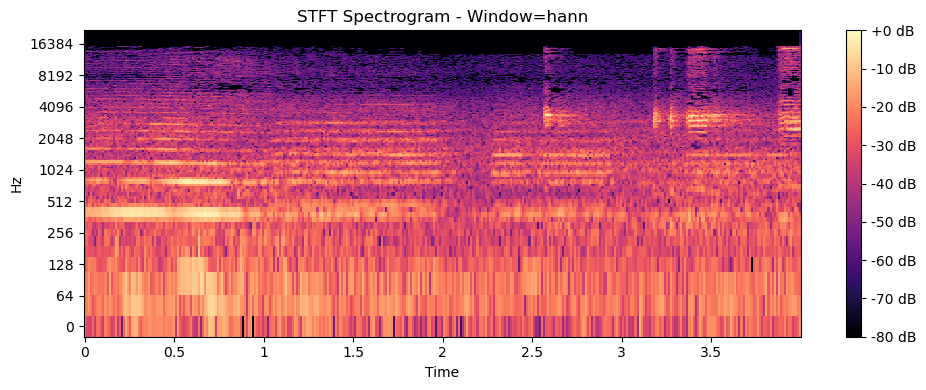


Class: dog_bark, Fold=6, File=208030-3-2-0.wav


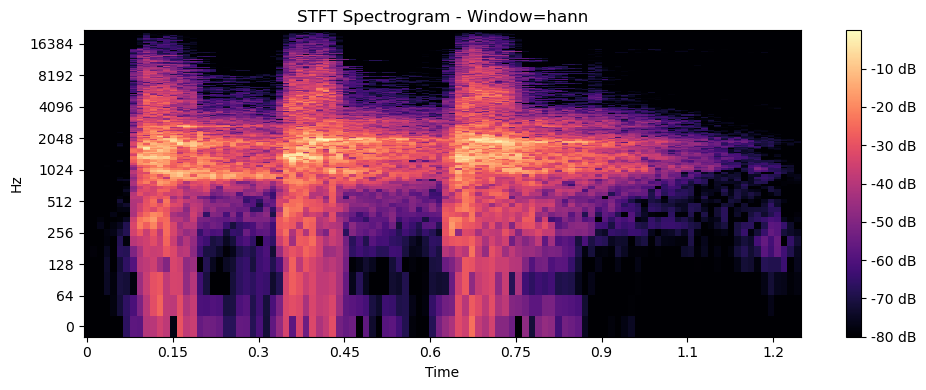


Class: gun_shot, Fold=1, File=46656-6-2-0.wav


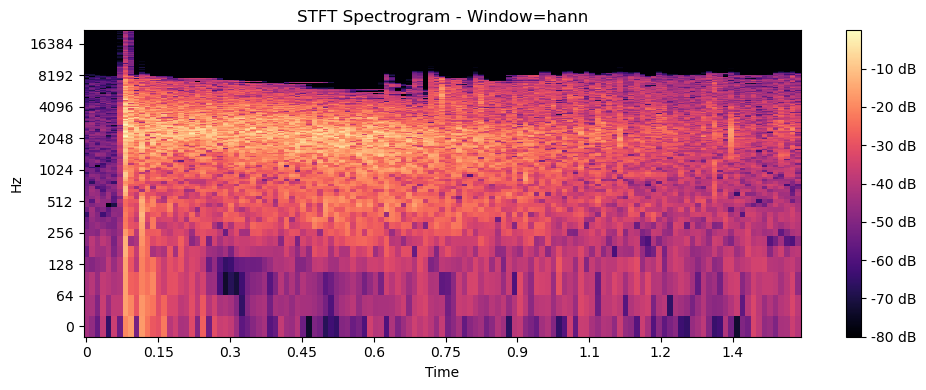


Class: siren, Fold=1, File=43806-8-0-0.wav


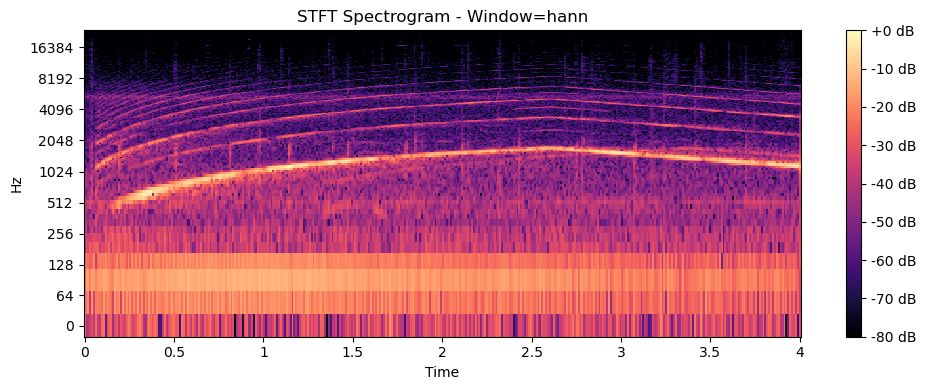


Comparing windows on sample:
  Class=siren, Fold=3, File=54898-8-0-2.wav


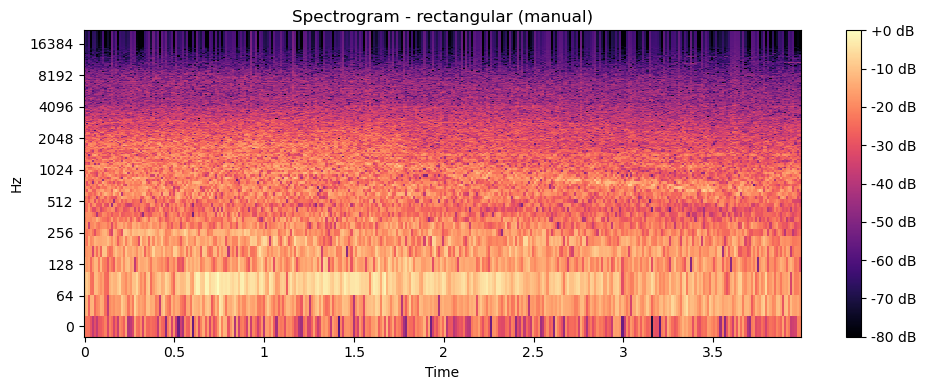

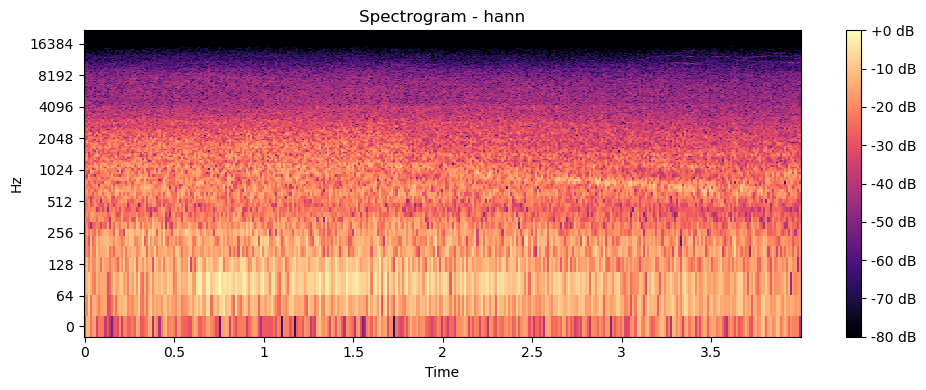

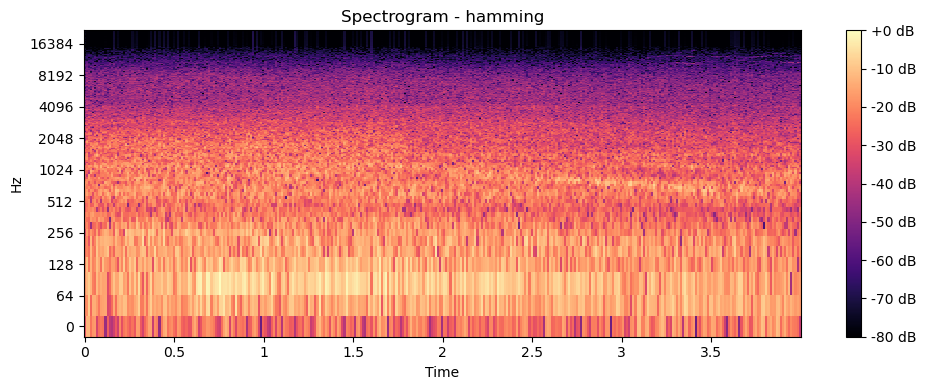


=== 10-FOLD EVALUATION FOR WINDOW = rect ===

=== Starting fold 1 for window=rect ===
Fold 1, Epoch 1/5, Train Loss: 2.0534, Train Acc: 0.257
Fold 1, Epoch 2/5, Train Loss: 1.5565, Train Acc: 0.439
Fold 1, Epoch 3/5, Train Loss: 1.3793, Train Acc: 0.503
Fold 1, Epoch 4/5, Train Loss: 1.2825, Train Acc: 0.538
Fold 1, Epoch 5/5, Train Loss: 1.1800, Train Acc: 0.575
[rect] Fold 1 TEST accuracy: 0.598

=== Starting fold 2 for window=rect ===
Fold 2, Epoch 1/5, Train Loss: 1.6202, Train Acc: 0.435
Fold 2, Epoch 2/5, Train Loss: 1.2231, Train Acc: 0.565
Fold 2, Epoch 3/5, Train Loss: 1.0916, Train Acc: 0.617
Fold 2, Epoch 4/5, Train Loss: 0.9971, Train Acc: 0.649
Fold 2, Epoch 5/5, Train Loss: 0.8715, Train Acc: 0.693
[rect] Fold 2 TEST accuracy: 0.555

=== Starting fold 3 for window=rect ===
Fold 3, Epoch 1/5, Train Loss: 2.0838, Train Acc: 0.275
Fold 3, Epoch 2/5, Train Loss: 1.5597, Train Acc: 0.451
Fold 3, Epoch 3/5, Train Loss: 1.3993, Train Acc: 0.508
Fold 3, Epoch 4/5, Train Loss: 1.

In [12]:
def main():
    visualize_samples_4_classes()
    visualize_one_sample_all_windows()

    for wt in WINDOW_TYPES:
        FEATURE_CACHE.clear()
        print(f"\n=== 10-FOLD EVALUATION FOR WINDOW = {wt} ===")
        accuracies = cross_fold_evaluation_no_val(wt)
        mean_acc = np.mean(accuracies)
        std_acc  = np.std(accuracies)
        print(f"{wt.upper()} - Fold Accuracies:", accuracies)
        print(f"{wt.upper()} - Mean Accuracy: {mean_acc:.3f}, Std: {std_acc:.3f}")

        plt.figure()
        plt.boxplot(accuracies)
        plt.title(f"{wt.upper()} - 10-Fold Accuracies")
        plt.ylabel("Test Accuracy")
        plt.savefig(f"boxplot_{wt}_10fold.png")
        plt.close()

if __name__ == "__main__":
    main()
